In [1]:
import json
from typing import TypedDict, Annotated, Literal
from IPython.display import Image, display

from langchain_core.runnables import RunnableConfig
from langchain_core.messages import ToolMessage, BaseMessage, AIMessage
from langchain_openai import ChatOpenAI
from langchain_tavily import TavilySearch
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode, tools_condition

In [2]:
model = ChatOpenAI(model='gpt-5-mini', temperature=0)

In [3]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

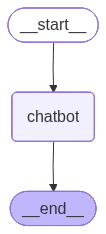

In [4]:
workflow = StateGraph(State)

def chatbot(state: State):
    return {'messages':[model.invoke(state['messages'])]}

workflow.add_node('chatbot', chatbot)
workflow.set_entry_point('chatbot')
workflow.add_edge('chatbot', END)

app = workflow.compile()
app

In [5]:
while True:
    user_input = input('User: ')

    if user_input.lower() in ['quit', 'exit', 'q', '종료']:
        print('Good Bye!')
        break
    else:
        for event in app.stream({'messages':('user', user_input)}):
            for value in event.values():
                print(f'Assistant: {value['messages'][-1].content}')

Assistant: 안녕! 나는 ChatGPT야. 편하게 챗GPT나 어시스턴트라고 불러도 돼. 뭐 도와줄까?
Good Bye!


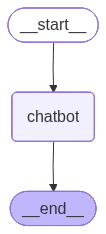

In [6]:
display(Image(app.get_graph().draw_mermaid_png()))

In [7]:
tool = TavilySearch(max_results=3)
tools = [tool]
tool.invoke('2025년 12월 18일 대한민국 서울의 날씨는?')

{'query': '2025년 12월 18일 대한민국 서울의 날씨는?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://world-weather.info/forecast/south_korea/seoul/december-2025/',
   'title': 'Weather in Seoul in December 2025',
   'content': '*   [9 +46° +32° 6 mph SW 30.2 inHg 48 %07:34 am 05:13 pm](https://world-weather.info/forecast/south_korea/seoul/14days/#2025-12-09). *   [11 +48° +41° 8.9 mph NW 30 inHg 38 %07:36 am 05:13 pm](https://world-weather.info/forecast/south_korea/seoul/14days/#2025-12-11). *   [13 +39° +37° 4.3 mph NW 29.9 inHg 75 %07:38 am 05:14 pm](https://world-weather.info/forecast/south_korea/seoul/14days/#2025-12-13). *   [14 +36° +32° 4.3 mph N 29.8 inHg 85 %07:38 am 05:14 pm](https://world-weather.info/forecast/south_korea/seoul/14days/#2025-12-14). *   [19 +50° +34° 2.5 mph W 30.1 inHg 54 %07:41 am 05:16 pm](https://world-weather.info/forecast/south_korea/seoul/14days/#2025-12-19). *   [20 +28° +23° 11.6 mph NW 30.2 inHg 33 %07:42 am 05:16 pm]

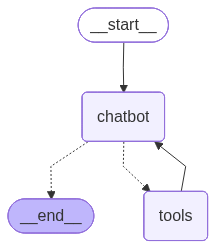

In [8]:
memory = MemorySaver()

workflow = StateGraph(State)

llm_with_tools = model.bind_tools(tools)
tool_node = ToolNode(tools=tools)

def chatbot(state: State):
    return {'messages':[llm_with_tools.invoke(state['messages'])]}

workflow.add_node('chatbot', chatbot)
workflow.add_node('tools', tool_node)

workflow.set_entry_point('chatbot')
workflow.add_conditional_edges(
    'chatbot',
    tools_condition
)
workflow.add_edge('tools', 'chatbot')

app = workflow.compile(checkpointer=memory)
app

In [9]:
config = {'configurable':{'thread_id':'1'}}
user_input = '안녕! 내 이름은 을지문덕이야. 네 이름은 뭐니?'

events = app.stream(
    {'messages':[('user', user_input)]},
    config,
    stream_mode='values'
)

for event in events:
    event['messages'][-1].pretty_print()

================================ Human Message =================================

안녕! 내 이름은 을지문덕이야. 네 이름은 뭐니?
================================== Ai Message ==================================

안녕하세요, 을지문덕님! 저는 ChatGPT(인공지능 비서)예요. 만나서 반가워요 — 무엇을 도와드릴까요?


In [10]:
user_input = '안녕! 내 이름을 기억해?'

events = app.stream(
    {'messages':[('user', user_input)]},
    config,
    stream_mode='values'
)

for event in events:
    event['messages'][-1].pretty_print()

================================ Human Message =================================

안녕! 내 이름을 기억해?
================================== Ai Message ==================================

네, 기억하고 있어요 — 을지문덕님. 이 대화 안에서는 이름을 기억하지만 세션이 끝나면 저장되지는 않아요. 앞으로도 이렇게 불러드릴까요?
